# Test Logical Error Rate of MWPF vs BPOSD(max_iter=5) on $p=0.002, [[90, 8, 10]]$ code

They give roughly $10^{-10}$ logical error rate so it's extremely time consuming to run these evaluations.
Nonetheless, it is worth exploring because at $p=0.02$, BPOSD gives about 3e-4 logical error rate while MWPF gives
about 1e-3 logical error rate. MWPF is 3x worse than BPOSD in this case.
We should definitely include that result in the MWPF paper; on the other hand, I believe that it is because
that physical error rate is at or beyond the "decoding threshold", only under which MWPF decoder starts to behave
like almost-linear decoding time and distance achieving.
Thus, I'm going to run the evaluation for 10x lower physical error rate and see.
That is, I'm going to run physical error rates at 0.002, 0.005 and 0.01.
These data points are going to help us better understand the decoder behavior.

In [1]:
p_vec: list[float] = [0.002, 0.005, 0.01, 0.02, 0.05]
def logical_error_rate(p: float) -> float:
    return 3e-4 * ((p / 0.02) ** 5)
shots_vec: list[int] = [round(100 / logical_error_rate(p)) for p in p_vec]
print("shots_vec:", shots_vec)

code: str = f"bb(n=90,k=8,d=10)"
noise_eval: str = 'f"depolarize(p={p})"'

slurm_maximum_jobs = 500
slurm_cores_per_node: int = 10  # (slurm_maximum_jobs // slurm_cores_per_node) should not exceed 200
slurm_mem_per_job: int = 4  # 4GB per job because we have very large instances
slurm_extra = dict(
    walltime = "1-00:00:00",  # adaptively shutdown if no more jobs
    queue = "scavenge",  # use with caution: dask does not seem to handle scavenge workers well
    job_extra_directives = ["--requeue"],  # use with scavenge partition will help spawn scavenged jobs
)

import multiprocessing
local_maximum_jobs = multiprocessing.cpu_count()
# local_maximum_jobs = 10

json_filename: str | None = None
force_finished: bool = True  # only plot the figure and do not run experiments

shots_vec: [33333333333, 341333333, 10666667, 333333, 3413]


In [2]:
decoder_vec = ["mwpf", "huf", "bposd(max_iter=5)", "bposd(max_iter=100)", "bpuf(max_iter=5)", "bpuf(max_iter=100)"]
# BPOSD(max_iter=100) has too high logical error rate, so we need to remove it from min shots submitter
min_shot_factor = [1, 0.05, 1, 0.0001, 1, 0.001]
factored_shots_vec = [max(round(shots * factor), 1000) for factor in min_shot_factor for shots in shots_vec]
print(factored_shots_vec)

[33333333333, 341333333, 10666667, 333333, 3413, 1666666667, 17066667, 533333, 16667, 1000, 33333333333, 341333333, 10666667, 333333, 3413, 3333333, 34133, 1067, 1000, 1000, 33333333333, 341333333, 10666667, 333333, 3413, 33333333, 341333, 10667, 1000, 1000]


In [3]:
from slugify import slugify
from dotmap import DotMap as dmap

if json_filename is None:
    json_filename = "zdat-" + slugify(code) + ".json"
print(json_filename)

zdat-bb-n-90-k-8-d-10.json


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from qec_lego_bench.hpc.monte_carlo import *
from qec_lego_bench.hpc.submitter import *
from qec_lego_bench.hpc.plotter import *
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [6]:
jobs = [MonteCarloJob(decoder, p) for decoder in decoder_vec for p in p_vec]


def monte_carlo_function(shots: int, decoder: str, p: float) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(
        decoder=decoder,
        code=code,
        noise=eval(noise_eval),
        max_shots=shots,
        max_errors=shots,
        no_progress=True,
        no_print=True,
    )
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)


print(monte_carlo_function(1000, decoder_vec[0], p_vec[0]))

(1000, LogicalErrorResult(errors=0, discards=0, panic_cases=None))


### Define the strategy to submit jobs

In [7]:
min_shot_submitter = MinShotsSubmitter(shots_vec=factored_shots_vec)
precision_submitter = PrecisionSubmitter(
    time_limit=10000 * 3600, min_precision=10, target_precision=0.21
)

def submitter(executor: MonteCarloJobExecutor) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shot_submitter(executor)
    if len(submit) == 0 and executor.no_pending():  # previous submitter all finished
        submit += precision_submitter(executor)
    return submit

## The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [ ]:
client_connector = SlurmClientConnector(
    slurm_maximum_jobs=slurm_maximum_jobs,
    slurm_cores_per_node=slurm_cores_per_node,
    slurm_mem_per_job=slurm_mem_per_job,
    slurm_extra=slurm_extra,
)

In [9]:
config = MonteCarloExecutorConfig()
config.max_submitted_job = max(config.max_submitted_job, 3 * slurm_maximum_jobs)
executor = MonteCarloJobExecutor(
    monte_carlo_function,
    jobs,
    config=config,
    filename=json_filename,
)

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

(I have to put them in the same block as the actual execution, otherwise it won't update in VScode)

In [10]:
import time  # add some sleep to let them work properly in VScode Jupyter notebook

time.sleep(0.2)
progress_plotter = JobProgressPlotter()
time.sleep(0.2)
memory_plotter = MemoryUsagePlotter()
time.sleep(0.2)
progress_plotter_by_name = JobProgressPlotter(sort_by_name=True)
time.sleep(0.2)


def callback(executor: MonteCarloJobExecutor):
    if not force_finished: progress_plotter(executor)
    time.sleep(0.1)
    progress_plotter_by_name(executor)
    time.sleep(0.1)
    if not force_finished: memory_plotter(executor)
    time.sleep(0.1)

print(
    "will shut down the cluster after job finishes; if this is not desired, set `shutdown_cluster` to False"
)

executor.execute(
    client_connector=client_connector,
    submitter=submitter,
    loop_callback=callback,
    shutdown_cluster=True,
    force_finished=force_finished,
)

''

''

,Status,JobKey,Job,Finished,Pending,Submitted,0 jobs,Total,Duration,Errors,Discards,Panics,Error Rate
0,finished,3800a7,"Job(bposd(max_iter=100), 0.002)",7081463883 (100%),0 (0%),0 (0%),0 (0%),7081463883,276017.5s (4600.3min),3843283,0,0,0.0005427(7)
1,finished,d03c1f,"Job(bposd(max_iter=100), 0.005)",341333333 (100%),0 (0%),0 (0%),0 (0%),341333333,16122.8s (268.7min),1044824,0,0,0.003061(8)
2,finished,203eb4,"Job(bposd(max_iter=100), 0.01)",10666667 (100%),0 (0%),0 (0%),0 (0%),10666667,780.5s (13.0min),110008,0,0,0.01031(8)
3,finished,16f796,"Job(bposd(max_iter=100), 0.02)",5669 (100%),0 (0%),0 (0%),0 (0%),5669,3.5s (0.1min),163,0,0,0.029(6)
4,finished,852a2c,"Job(bposd(max_iter=100), 0.05)",3235 (100%),0 (0%),0 (0%),0 (0%),3235,3.4s (0.1min),162,0,0,0.05(1)
5,finished,c690a0,"Job(bposd(max_iter=5), 0.002)",135010535013 (100%),0 (0%),0 (0%),0 (0%),135010535013,5340918.5s (89015.3min),181,0,0,1.3(3)e-09
6,finished,60910a,"Job(bposd(max_iter=5), 0.005)",4480573518 (100%),0 (0%),0 (0%),0 (0%),4480573518,268477.7s (4474.6min),290,0,0,6(1)e-08
7,finished,71ef8e,"Job(bposd(max_iter=5), 0.01)",3578447612 (100%),0 (0%),0 (0%),0 (0%),3578447612,270847.1s (4514.1min),3875,0,0,1.08(4)e-06
8,finished,cfe8ce,"Job(bposd(max_iter=5), 0.02)",7952373 (100%),0 (0%),0 (0%),0 (0%),7952373,459.4s (7.7min),212,0,0,2.7(5)e-05
9,finished,697442,"Job(bposd(max_iter=5), 0.05)",40713 (100%),0 (0%),0 (0%),0 (0%),40713,6.0s (0.1min),195,0,0,0.0048(9)


will shut down the cluster after job finishes; if this is not desired, set `shutdown_cluster` to False


## Plot the data

mwpf 0.002 Stats{ Stats{ pL = 153/1066492836153= 1.4(3)e-10, speed=5.83e-05s/S }
mwpf 0.005 Stats{ Stats{ pL = 197/8128676570= 2.4(4)e-08, speed=1.09e-04s/S }
mwpf 0.01 Stats{ Stats{ pL = 1517/1048427021= 1.4(1)e-06, speed=2.52e-04s/S }
mwpf 0.02 Stats{ Stats{ pL = 157/1546295= 0.00010(2), speed=5.20e-04s/S }
mwpf 0.05 Stats{ Stats{ pL = 170/8261= 0.021(4), speed=4.61e-03s/S }
huf 0.002 Stats{ Stats{ pL = 316/27705731815= 1.1(2)e-08, speed=3.43e-05s/S }
huf 0.005 Stats{ Stats{ pL = 171/341333333= 5(1)e-07, speed=4.22e-05s/S }
huf 0.01 Stats{ Stats{ pL = 170/16493828= 1.0(2)e-05, speed=7.28e-05s/S }
huf 0.02 Stats{ Stats{ pL = 419/1391695= 0.00030(4), speed=1.23e-04s/S }
huf 0.05 Stats{ Stats{ pL = 198/8350= 0.024(4), speed=1.30e-03s/S }
bposd(max_iter=5) 0.002 Stats{ Stats{ pL = 181/135010535013= 1.3(3)e-09, speed=3.96e-05s/S }
bposd(max_iter=5) 0.005 Stats{ Stats{ pL = 290/4480573518= 6(1)e-08, speed=5.99e-05s/S }
bposd(max_iter=5) 0.01 Stats{ Stats{ pL = 3875/3578447612= 1.08(4)e-06,

Text(0.5, 1.0, 'Bivariate Bicycle Code $[[90, 8, 10]]$ (code-capacity noise))')

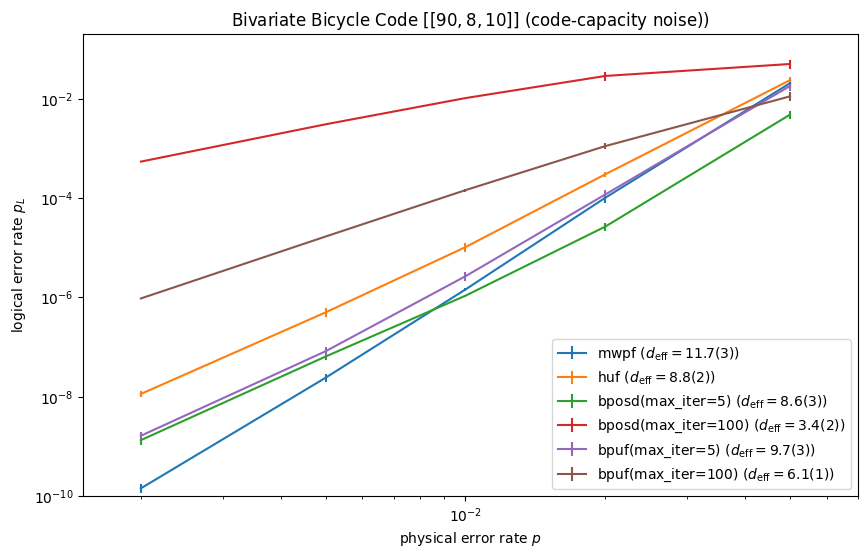

In [34]:
from uncertainties import ufloat

fig = plt.figure()
fig.set_size_inches(10, 6)
ax = fig.gca()
ax.clear()
ax.set_xlabel("physical error rate $p$")
ax.set_ylabel("logical error rate $p_L$")
ax.set_xlim(0.0015, 0.07)
ax.set_xscale("log")
ax.set_ylim(1e-10, 2e-1)
ax.set_yscale("log")


p1 = sorted(p_vec)[0]
p2 = sorted(p_vec)[3]


for decoder in decoder_vec:
    x_vec = []
    y_vec = []
    err_vec = []

    def get_stats(p: float) -> Stats:
        job = executor.get_job(decoder, p)
        return job.result.stats_of(job)

    for p in p_vec:
        stats = get_stats(p)
        x_vec.append(p)
        y_vec.append(stats.failure_rate_value)
        err_vec.append(stats.failure_rate_uncertainty)
        print(decoder, p, stats)
    # also calculate the slope using the last two points
    min_stats = get_stats(p1)
    second_min_stats = get_stats(p2)
    diff_log_pL = math.log(second_min_stats.failure_rate_value) - math.log(
        min_stats.failure_rate_value
    )
    diff_log_p = math.log(p2) - math.log(p1)
    slope = diff_log_pL / diff_log_p
    diff_error = (
        math.log(1 + min_stats.failure_rate_uncertainty / min_stats.failure_rate_value)
        + math.log(
            1 + second_min_stats.failure_rate_uncertainty
            / second_min_stats.failure_rate_value
        )
    ) / diff_log_p
    d_eff = 2 * ufloat(slope, diff_error)

    ax.errorbar(
        x_vec, y_vec, err_vec, label=decoder + " ($d_{\\text{eff}}=$" + f"${d_eff:.1uS})$"
    )

ax.legend()
ax.set_title("Bivariate Bicycle Code $[[90, 8, 10]]$ (code-capacity noise))")